In [1]:
import polars as pl
import turbofats
from tqdm import tqdm
import os
from scripts.utils import read_light_curves
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy

In [3]:
with open("dataset/4clasess.pkl","rb") as f: ##se carga el dataset con mas de 20 observaciones,sin nans,-inf,inf 
    data = pkl.load(f)

In [2]:
features = pl.read_csv("data.csv")
features

,PeriodLS_v2,Mean,GP_DRW_sigma,GP_DRW_tau,IAR_phi,Amplitude,ExcessVar,Meanvariance,Std,SF_ML_amplitude,id
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
0,0.296472,2.7079e-18,0.059642,1.819084,0.510499,1.714204,-6.1561e34,3.6930e17,1.0,0.112959,0
1,0.056712,8.4224e-17,0.000004,1.437435,0.99171,2.051243,-2.6032e32,1.1873e16,1.0,-0.5,1
2,0.051169,2.0186e-17,9.7203e-7,1.293458,1.0,1.887421,-3.7587e33,4.9540e16,1.0,-0.5,2
3,0.064801,8.5100e-17,0.141447,19.375533,0.997312,2.064402,-7.5862e30,1.1751e16,1.0,0.758753,3
4,0.660869,1.4240e-16,0.000002,1.049287,0.913965,1.640656,-4.3985e31,7.0226e15,1.0,0.226225,4
…,…,…,…,…,…,…,…,…,…,…,…
178749,0.291304,-9.8334e-17,0.994311,0.033928,4.2301e-13,1.695227,9.4420e31,-1.0169e16,1.0,1.109116,178749
178750,0.057773,5.9212e-17,0.000002,0.590208,0.123261,1.848301,-3.9507e32,1.6888e16,1.0,15.0,178750
178751,0.318498,-8.1416e-17,1.05257,0.514109,0.177959,1.399494,1.5078e32,-1.2283e16,1.0,2.284552,178751


preguntar que utiliza el profe para dejar corriendo programas  (SCREEN byobu)
en turbofats no hay features problemáticos, solo features que arrojan warnings de división por cero

In [25]:
map_num2class = {
    0:'RRL',
    1:'Cepheid',
    2:'EB',
    3:'CLAGN'
}

In [38]:
for i,clase in enumerate(data):
    if clase['class'] == 0:
        print(i)
        break

164424


In [56]:
fs = turbofats.FeatureSpace(feature_list=["PeriodLS_v2"])
df = pd.DataFrame({
        "time": time,
        "magnitude": mag,
        "error": err
    })
df['id']=0
df.set_index('id', inplace=True)
fs.calculate_features(lightcurve=df)

,PeriodLS_v2
oid,
0,0.961295


1.040200 0.982741
0.520100 0.950572
1.560400 0.845482
0.851700 0.743677
3.120800 0.742149
1.728300 0.724224
1.730600 0.699882
2.439400 0.675285
20.390300 0.667291
3.309600 0.644237
1.0402000000000005
0.9613535858488748


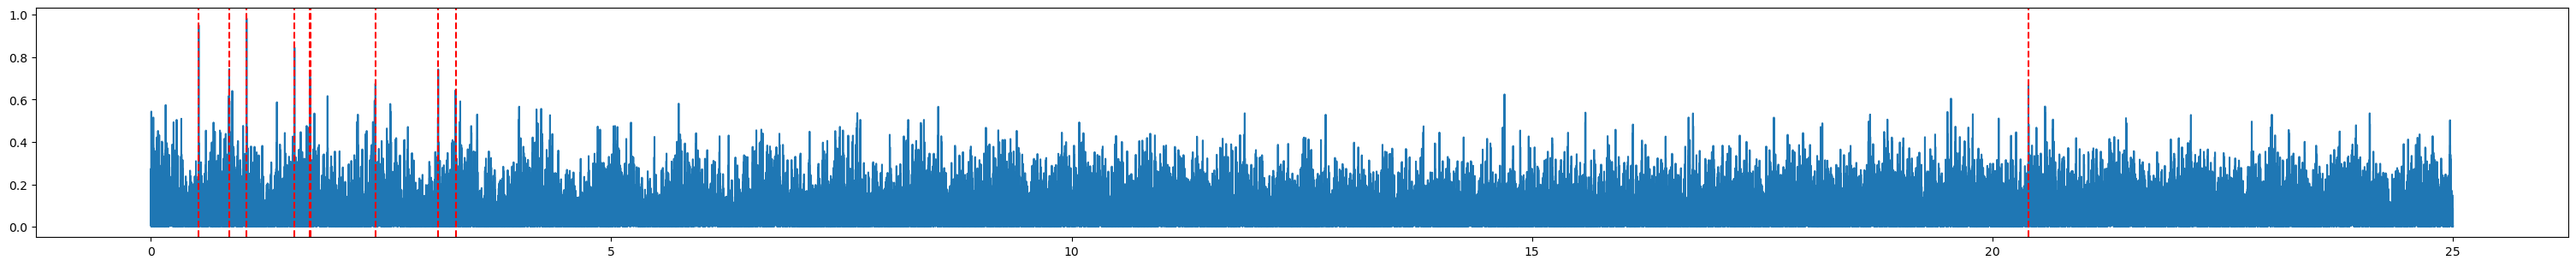

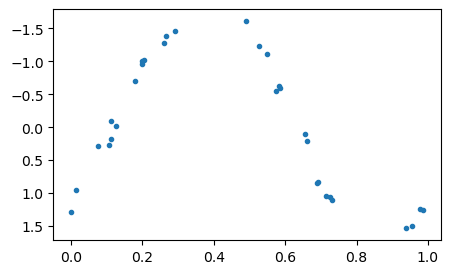

In [57]:
from astropy.timeseries import LombScargle
import numpy as np
idx = 150001
time = np.array(data[idx]['mjd'])*1000
mag = data[idx]['flux']
err = data[idx]['err']
freq = np.arange(1e-3, 25, 1e-4)
power = LombScargle(time, mag, err).power(freq)

fig, ax = plt.subplots(figsize=(30,3), constrained_layout=True)
ax.plot(freq, power)
local_max = np.where((power[1:-1] > power[:-2]) & (power[1:-1] > power[2:]))[0]+1
top_freqs = np.argsort(power[local_max])[::-1]
for top_freq in top_freqs[:10]:
    print(f'{freq[local_max][top_freq]:0.6f} {power[local_max][top_freq]:0.6f}')
    ax.axvline(freq[local_max][top_freq], c='r', ls='--')
print(freq[np.argmax(power)])
p_best = 1/freq[np.argmax(power)]
print(p_best)
fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.mod(time,p_best)/p_best, mag, err, fmt='.')
ax.invert_yaxis() 

31
0.18138944275787458


Text(0.5, 1.0, 'Cepheid')

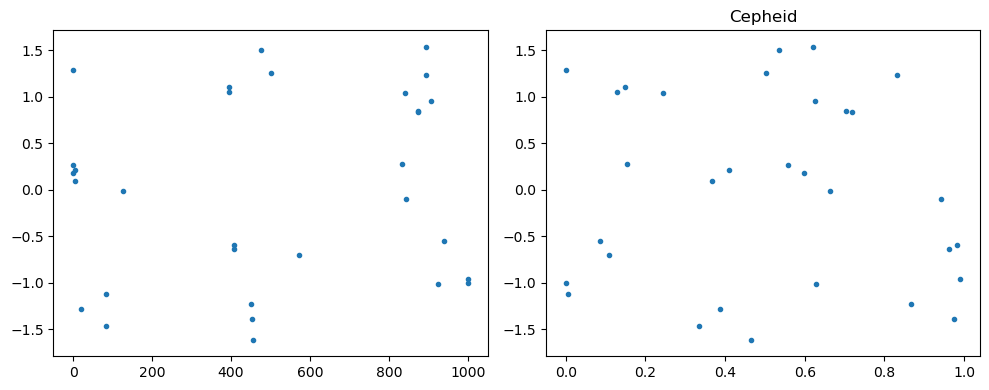

In [53]:
idx = 150001
mjd = np.array(data[idx]['mjd'])*1000
flux = data[idx]['flux']
err = data[idx]['err']
print(len(mjd))
fig,ax = plt.subplots(1,2,tight_layout=True,figsize=(10,4))
ax[0].errorbar(mjd,flux,err,fmt=".")
period = final_df.iloc[idx]["PeriodLS_v2"]
print(period)
phase = np.mod(mjd,period)/period
ax[1].errorbar(phase,flux,err,fmt=".")
ax[1].set_title(map_num2class[data[idx]["class"]])

Inspección de periodos muy malos. Los features enteros seran muy malos? D:
